### Rentcast Apartments - Exploratory Data Analysis

Authors: Kaiwen Dong

Perpetual hopes to place foodware collection bins at "large" apartments defined as buildings with 90+ rooms or another suitable proxy. The purpose of this notebook is to investigate the viability of using **[RentCast](https://www.rentcast.io/api)** for apartment size approximations. An API key is needed to fetch data, but the analysis below uses results collected previously for one of Perpetual's partner cities: Galveston, Texas.


#### Imports


In [1]:
%load_ext autoreload
%autoreload 2

# Standard library imports
from typing import Dict, Tuple

# Third-party imports
import pandas as pd
from IPython.display import HTML

# Application imports
from utils.constants import DATA_DIR
from utils.rentcast import (
    draw_histogram,
    draw_scatterplot,
    parse_street_address,
    preview_dataset,
    view_against_yelp,
)

#### 1. Data Characteristics

At the time of writing, there are 1,206 apartment records available from the Rentcast API for Galveston, Texas, of which 1,087 list a square footage and 385 a lot size.


In [2]:
# Load and summarize data
apts_df = pd.read_json(f"{DATA_DIR}/rentcast/galveston/TX_Apar.json")
preview_dataset(apts_df)

'1,206 record(s) and 26 column(s)'

Index(['id', 'formattedAddress', 'addressLine1', 'addressLine2', 'city',
       'state', 'zipCode', 'county', 'latitude', 'longitude', 'propertyType',
       'yearBuilt', 'lastSaleDate', 'squareFootage', 'lotSize', 'assessorID',
       'legalDescription', 'subdivision', 'features', 'taxAssessments',
       'propertyTaxes', 'owner', 'ownerOccupied', 'bathrooms', 'lastSalePrice',
       'bedrooms'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1206 non-null   object 
 1   formattedAddress  1206 non-null   object 
 2   latitude          1206 non-null   float64
 3   longitude         1206 non-null   float64
 4   yearBuilt         481 non-null    float64
 5   propertyType      1206 non-null   object 
 6   squareFootage     1087 non-null   float64
 7   lotSize           385 non-null    float64
 8   ownerOccupied     58 non-null     float64
 9   lastSalePrice     7 non-null      float64
 10  bathrooms         1137 non-null   float64
 11  bedrooms          1104 non-null   float64
 12  features          538 non-null    object 
dtypes: float64(9), object(4)
memory usage: 122.6+ KB


None

,latitude,longitude,yearBuilt,squareFootage,lotSize,ownerOccupied,lastSalePrice,bathrooms,bedrooms
count,1206.000000,1206.000000,481.000000,1087.000000,385.000000,58.000000,7.000000e+00,1137.000000,1104.000000
mean,29.287627,-94.810062,1967.297297,2776.970561,43130.602597,0.120690,3.970571e+05,1.271328,1.838768
std,0.019816,0.029823,21.557795,10235.062358,79903.426548,0.328611,4.723849e+05,0.608801,1.371019
min,29.183246,-95.015871,1860.000000,247.000000,723.000000,0.000000,3.500000e+04,0.500000,0.000000
25%,29.270687,-94.833420,1958.000000,680.000000,5140.000000,0.000000,1.605000e+05,1.000000,1.000000
50%,29.290230,-94.803405,1969.000000,890.000000,10036.000000,0.000000,2.667000e+05,1.000000,2.000000
75%,29.304306,-94.786362,1973.000000,1580.000000,17999.000000,0.000000,3.658500e+05,1.000000,2.000000
max,29.527598,-94.754627,2024.000000,191328.000000,293303.000000,1.000000,1.425000e+06,11.000000,23.000000


,id,formattedAddress,latitude,longitude,yearBuilt,propertyType,squareFootage,lotSize,ownerOccupied,lastSalePrice,bathrooms,bedrooms,features
0,"4400-Ave-N,-Galveston,-TX-77550","4400 Ave N, Galveston, TX 77550",29.290238,-94.814662,1985.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"2101-Church-Rear-St,-Galveston,-TX-77550","2101 Church Rear St, Galveston, TX 77550",29.304090,-94.791150,1927.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"7302-Ave-P,-1-2-Ave,-Galveston,-TX-77551","7302 Ave P, 1/2 Ave, Galveston, TX 77551",29.274965,-94.847144,1985.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"3102-69th-St,-Galveston,-TX-77551","3102 69th St, Galveston, TX 77551",29.268001,-94.835433,1983.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"3428-Cove-View-Blvd,-Galveston,-TX-77554","3428 Cove View Blvd, Galveston, TX 77554",29.247872,-94.868845,1985.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN


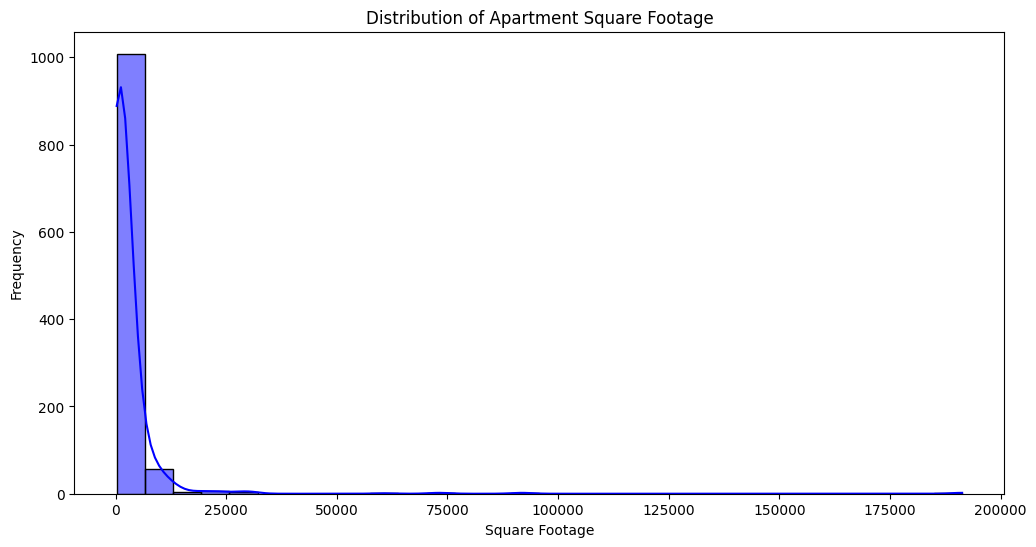

None

In [3]:
# Visualize the apartment square footage
draw_histogram(
    series=apts_df["squareFootage"],
    title="Distribution of Apartment Square Footage",
    x_label="Square Footage",
)

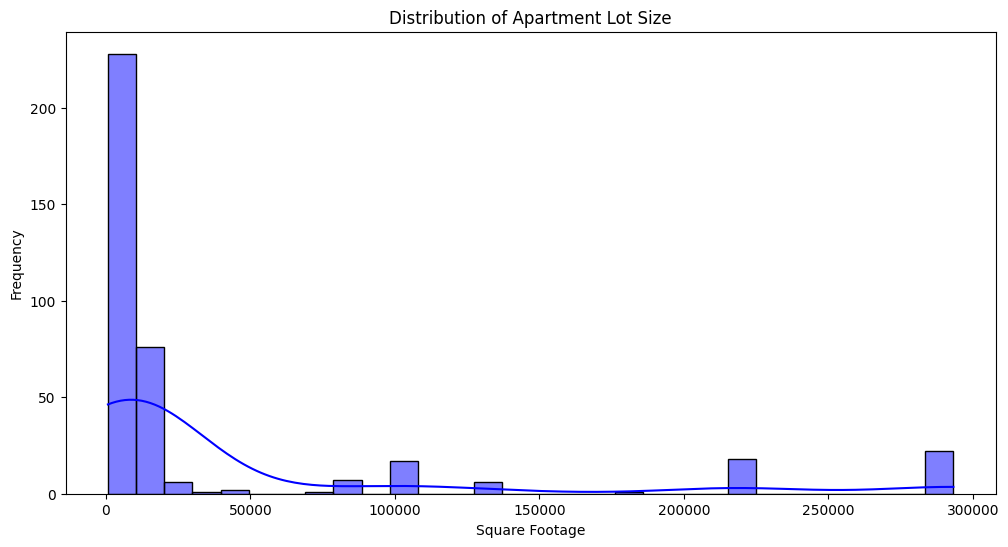

None

In [4]:
draw_histogram(
    series=apts_df["lotSize"],
    title="Distribution of Apartment Lot Size",
    x_label="Square Footage",
)

The unstructured (JSON) field `features` must be parsed to extract the `roomCount` and `unitCount` field for each record. According to a representative from Rentcast's customer support:

- The "unitCount" field is used to indicate the number of individual apartment units in a multi-family building. For example, a duplex has 2 units, and a quad has 4 units. For single family properties this field is either going to be absent, or will have a value of 1.

- The "roomCount" field is used to indicate the total number of rooms in the property, when that information is available. It's different from bedroom/bathroom count as it counts all of the rooms, including the living room, kitchen, dining room, etc.

Overall, 30 records (~2.5 percent) in the data have a room count while 27 (~2.2 percent) have a unit count.


In [5]:
# Define local function to parse room and unit count columns
def parse_feature(feature: Dict) -> Tuple[int, int]:
    if not isinstance(feature, dict):
        return None, None
    room_count = feature.get("roomCount")
    unit_count = feature.get("unitCount")
    return room_count, unit_count


# Add columns and preview
apts_df["roomCount"], apts_df["unitCount"] = zip(
    *apts_df["features"].map(parse_feature)
)
apts_df.query("(roomCount == roomCount) | (unitCount == unitCount)").head(2)

,id,formattedAddress,addressLine1,addressLine2,city,state,zipCode,county,latitude,longitude,...,features,taxAssessments,propertyTaxes,owner,ownerOccupied,bathrooms,lastSalePrice,bedrooms,roomCount,unitCount
10,"3421-Ave-N,-Galveston,-TX-77550","3421 Ave N, Galveston, TX 77550",3421 Ave N,None,Galveston,TX,77550,Galveston,29.291903,-94.804125,...,"{'architectureType': 'Condo / Apartment', 'ext...","{'2023': {'value': 491000, 'land': 77140, 'imp...",{'2018': {'total': 3004}},"{'names': ['Kelsey R Maxson', 'KELSEY LAURIE A...",0.0,NaN,NaN,NaN,10.0,NaN
17,"1302-39th-St,-Galveston,-TX-77550","1302 39th St, Galveston, TX 77550",1302 39th St,None,Galveston,TX,77550,Galveston,29.292437,-94.809282,...,"{'architectureType': 'Condo / Apartment', 'coo...","{'2023': {'value': 229900, 'land': 33320, 'imp...",{'2018': {'total': 2096}},"{'names': ['BMI INVS INC'], 'mailingAddress': ...",0.0,NaN,NaN,NaN,10.0,NaN


In [6]:
# Display room counts
room_counts = apts_df.query("roomCount == roomCount")[["roomCount"]]
display(HTML("<b>Room Counts</b>"))
display(len(room_counts))
display(room_counts.describe())

# Display unit counts
unit_counts = apts_df.query("unitCount == unitCount")[["unitCount"]]
display(HTML("<b>Unit Counts</b>"))
display(len(unit_counts))
display(unit_counts.describe())

30

,roomCount
count,30.000000
mean,8.233333
std,2.314621
min,1.000000
25%,8.000000
50%,8.000000
75%,10.000000
max,12.000000


27

,unitCount
count,27.000000
mean,1.703704
std,1.353480
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000


#### 2. Correlations

We want to investigate correlations among apartment square footage, lot square footage, and unit count. If unit counts appear in the data infrequently but strongly correlate with lot or apartment square footage, we could use one of the latter columns to identify large apartments instead.


,squareFootage,lotSize,unitCount
squareFootage,1.000000,0.212449,0.528813
lotSize,0.212449,1.000000,0.522338
unitCount,0.528813,0.522338,1.000000


<Figure size 1000x600 with 0 Axes>

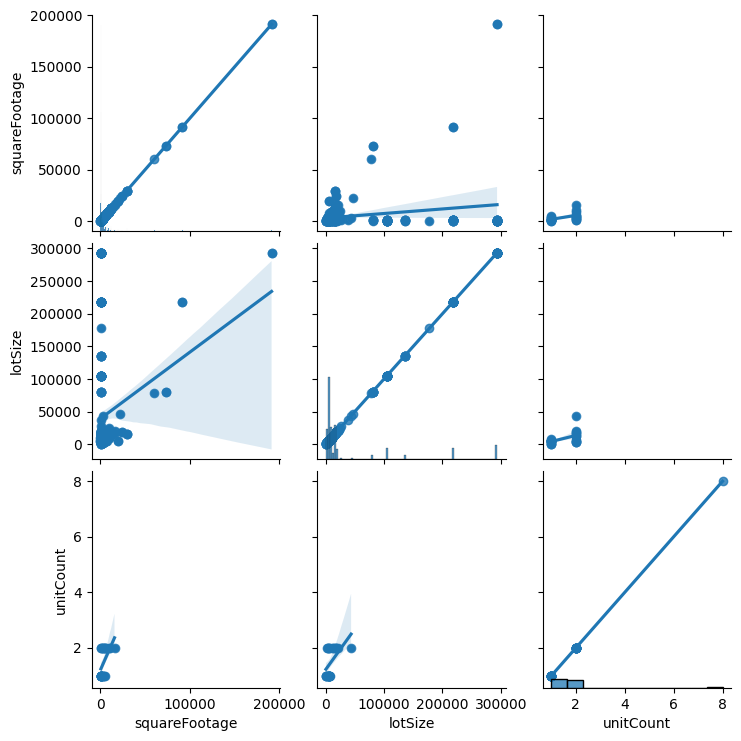

In [7]:
# Examine relationship between square footage and room count
apt_size_proxies_df = apts_df[["squareFootage", "lotSize", "unitCount"]]
display(HTML("<b>Pearson Correlation Coefficient</b>"))
display(apt_size_proxies_df.corr())
draw_scatterplot(
    df=apt_size_proxies_df,
    title="Relationships among Apartment Size Proxies",
)

We observe moderate positive correlations of ~0.53 between unit counts and apartment square footage and ~0.52 between unit counts and lot square footage. There is also a weak correlation of ~0.21 between apartment and lot square footage.


#### 3. Comparisions with Yelp Apartments

To gage how accurate and up-to-date the Rentcast apartment data is relative to apartments fetched from the Yelp Fusion API, we perform record linkage on the two datasets.


In [8]:
# Load and preview Yelp records
yelp_df = pd.read_excel(
    f"{DATA_DIR}/padlet/Padlet - City of Galveston Texas Yelp.xlsx"
)
yelp_df.head(2)

,Post number,Section,Subject,Body,Attachment,Attachment caption,Location,Latitude,Longitude,Author,Created At,Updated At
0,1,2,Leeland House,Source: yelp\nCategories: Restaurants,https://www.yelp.com/biz/leeland-house-galvest...,Website Url,"2711 Market St, Galveston, TX 77550",29.303881,-94.798849,Launa Greer (launagreer),2024-03-29 21:15:17 UTC,2024-03-29 21:15:17 UTC
1,2,Outdoor Bins,Chick-fil-A,Source: yelp\nCategories: Fast Food|Chicken Sh...,https://www.yelp.com/biz/chick-fil-a-galveston...,Website Url,"2501 Seawall Blvd, Galveston, TX 77550",29.288736,-94.790329,Launa Greer (launagreer),2024-03-29 21:15:18 UTC,2024-03-29 21:15:18 UTC


In [9]:
# Filter to include apartments only
yelp_apts_df = yelp_df[
    yelp_df["Body"].apply(lambda b: "apartments" in b.lower())
]

# Normalize street addresses
yelp_apts_df = parse_street_address(yelp_apts_df, address_col="Location")
apts_df = parse_street_address(apts_df, address_col="formattedAddress")

In [10]:
# Compare sets of points
view_against_yelp(apts_df, yelp_apts_df)

'18 of the 26 Yelp apartments had a match in the Rentcast dataset (0.692308 percent).'

#### Conclusions

- Based on the exploratory data analysis of apartment records from Rentcast in Galveston, Texas, we observed several key insights. The dataset comprises 1,206 apartment records, with the majority listing square footage and a smaller subset providing lot size details. The `roomCount` and `unitCount` fields, while present, show inconsistent population, which affects their utility in analysis. The distribution analysis reveals a wide range of apartment sizes, indicating a diverse housing market in Galveston. Most apartments fall within a specific square footage range, with fewer large apartments.

- Moderate positive correlations between unit counts and both apartment square footage (~0.53) and lot square footage (~0.52) suggest that square footage metrics can serve as proxies for unit count, which is crucial for identifying large apartments for foodware collection bin placement. The weak correlation (~0.21) between apartment and lot square footage indicates these metrics measure different aspects of apartment size.

- Comparisons between Rentcast and Yelp apartment data highlight overlaps and discrepancies due to differences in data sources and definitions. Normalizing street addresses is essential for accurate record linkage and comparison. These insights suggest that while apartment square footage is a useful proxy for unit count, using a combination of metrics (square footage, lot size, and available unit counts) will provide a more accurate approximation of apartment size and inform bin placement decisions. For future work, improving data cleaning and normalization, expanding the dataset to more cities, and continuously validating data sources will enhance the reliability and applicability of the findings.
